In [1]:
import sys
import os
import requests
import time
import datetime
from tqdm import tqdm

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('../mae')

import models_mae

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define the utils
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir: str, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def show_prediction(x: torch.tensor, y: torch.tensor, mask: torch.tensor):
    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()
    
def load_image(path: str):
    img = Image.open(path)
    img = img.resize((224, 224))
    img = np.array(img) / 255.

    assert img.shape == (224, 224, 3)

    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    
    return img

def predict(model: torch.nn.Module, image: np.ndarray, mask_ratio: float = 0.75):
    # prepare input
    x = torch.tensor(image)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    _, y, mask = model(x.float(), mask_ratio=mask_ratio)
    
    # unbatch, unpatchify data
    y = y.detach().cpu()
    mask = mask.detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)
    
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y)
    
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping !!!
    mask = torch.einsum('nchw->nhwc', mask)
    
    return x, y, mask

In [3]:
# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth -P ../weights/

File ‘../weights/mae_visualize_vit_large.pth’ already there; not retrieving.



In [4]:
checkpoint_path = '../weights/mae_visualize_vit_large.pth'
model_name = 'mae_vit_large_patch16'
image_folder = "../data/images/train/_0-JkwZ9o4Q_8-5-rgb_front"
image_names = os.listdir(image_folder)

# load model
model_mae = prepare_model(checkpoint_path, model_name)
print('Model loaded.')

<All keys matched successfully>
Model loaded.


100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


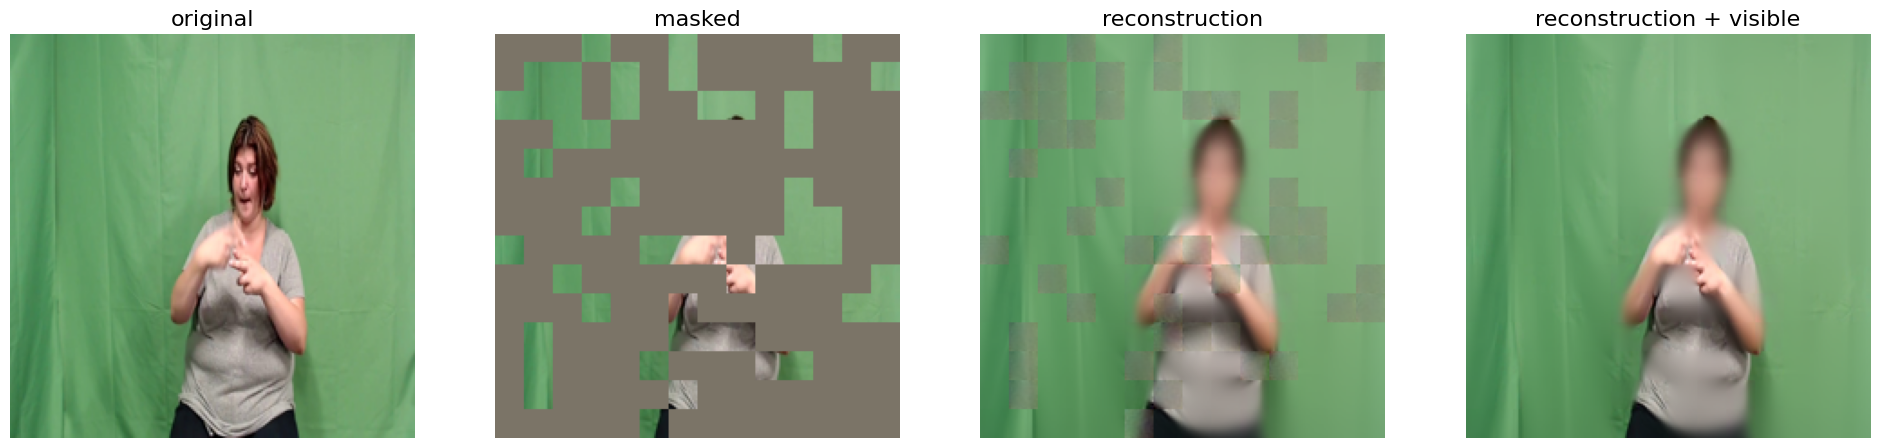

Prediction time 0:00:43
Average prediction time 0.903s


In [5]:
start_time = time.time()
for image_name in tqdm(image_names):
    image_path = os.path.join(image_folder, image_name)
    image = load_image(image_path)
    x, y, mask = predict(model_mae, image)
    
# show last prediction
show_prediction(x, y, mask)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
average_time = total_time/len(image_names)
print(f'Prediction time {total_time_str}')
print(f'Average prediction time {average_time:.3f}s')